In [2]:
import json
import random
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchvision
import numpy as np
from IPython.display import display
from torchvision.transforms import functional as F
from PIL import Image
from mpl_toolkits.mplot3d.axes3d import Axes3D
from lib.visualize_groundtruth import create_index, viz2d, plt_imshow, bgr2rgb, plt_3dplot, coco_to_camma_kps, progress_bar
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)

Using device: cpu


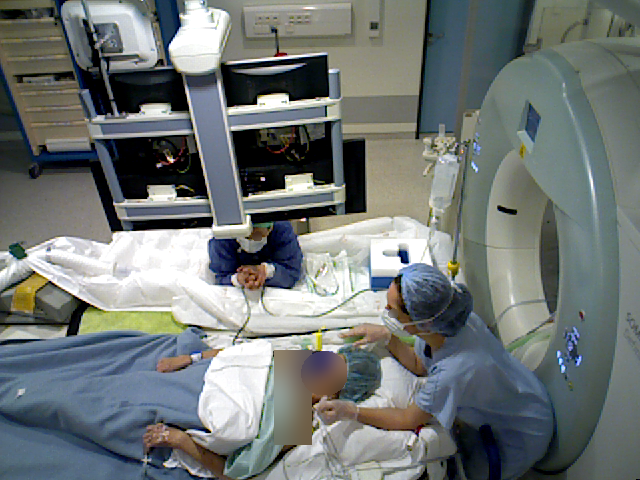

In [117]:
path = "./camma_mvor_dataset/day1/cam1/color/000005.png"
imgs = Image.open(path)
imgs

In [118]:
# convert input multi-view images to pytorch tensors
imgs_tensor = [F.to_tensor(imgs.convert('RGB')).to(DEVICE)]
imgs_tensor

[tensor([[[0.2784, 0.2824, 0.2627,  ..., 0.3765, 0.3686, 0.3569],
          [0.2980, 0.3020, 0.3020,  ..., 0.3765, 0.3765, 0.3608],
          [0.2902, 0.3098, 0.3098,  ..., 0.3490, 0.3569, 0.3490],
          ...,
          [0.2784, 0.2824, 0.2706,  ..., 0.3098, 0.3255, 0.3216],
          [0.2706, 0.2745, 0.2941,  ..., 0.3176, 0.3137, 0.3098],
          [0.2745, 0.2784, 0.2902,  ..., 0.0000, 0.0000, 0.0627]],
 
         [[0.2314, 0.2353, 0.2353,  ..., 0.4275, 0.4078, 0.3961],
          [0.2824, 0.2902, 0.2863,  ..., 0.4235, 0.4157, 0.4039],
          [0.2902, 0.3098, 0.3098,  ..., 0.4000, 0.4039, 0.3961],
          ...,
          [0.3412, 0.3451, 0.3490,  ..., 0.3529, 0.3451, 0.3412],
          [0.3529, 0.3569, 0.3529,  ..., 0.3608, 0.3529, 0.3490],
          [0.3608, 0.3647, 0.3686,  ..., 0.0000, 0.0000, 0.0549]],
 
         [[0.1294, 0.1333, 0.1294,  ..., 0.3765, 0.3843, 0.3765],
          [0.1569, 0.1608, 0.1686,  ..., 0.3608, 0.4314, 0.4157],
          [0.1843, 0.2000, 0.1922,  ...,

In [119]:
# load the model and pre-trained weights
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# put the model on the eval mode and assign either "cpu" or "gpu" device
model.eval()
model = model.to(DEVICE)

# run the model on the multiview image
with torch.no_grad():
    predictions_2d = model(imgs_tensor)
predictions_2d[0]

{'boxes': tensor([[288.8207, 263.1653, 553.0815, 470.8674],
         [205.3444, 215.8238, 303.3320, 289.8535],
         [320.7161, 259.5546, 483.4768, 432.1044],
         [462.3588,  55.2495, 627.5752, 330.5004],
         [335.1356, 276.5583, 433.1107, 414.9916],
         [156.1115, 343.5595, 221.4716, 374.0068],
         [103.8316, 329.0053, 495.1273, 476.0210],
         [317.3772, 339.6322, 433.1620, 419.0130],
         [356.6860,  42.3733, 624.6863, 448.7110]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'scores': tensor([0.9977, 0.9936, 0.3319, 0.3273, 0.2888, 0.1227, 0.1168, 0.0824, 0.0551]),
 'keypoints': tensor([[[401.1765, 319.1311,   1.0000],
          [396.9819, 311.3498,   1.0000],
          [397.5811, 310.7512,   1.0000],
          [411.3635, 314.9412,   1.0000],
          [435.9319, 293.3928,   1.0000],
          [458.7027, 366.4178,   1.0000],
          [460.5004, 318.5326,   1.0000],
          [411.3635, 417.8944,   1.0000],
          [420.9511, 366.4178,   1.0000]

In [120]:
# get the bounding boxes and keypoint detections
boxes = predictions_2d[0]["boxes"].cpu().numpy()
keypoints = predictions_2d[0]["keypoints"].cpu().numpy()

In [121]:
boxes

array([[288.8207  , 263.16528 , 553.08154 , 470.86737 ],
       [205.34436 , 215.82382 , 303.33203 , 289.85352 ],
       [320.71606 , 259.55457 , 483.4768  , 432.1044  ],
       [462.35876 ,  55.249516, 627.5752  , 330.5004  ],
       [335.13556 , 276.5583  , 433.1107  , 414.99164 ],
       [156.11148 , 343.55948 , 221.47162 , 374.00684 ],
       [103.83155 , 329.00534 , 495.1273  , 476.02103 ],
       [317.3772  , 339.6322  , 433.16205 , 419.01303 ],
       [356.686   ,  42.37326 , 624.6863  , 448.71103 ]], dtype=float32)

In [122]:
keypoints

array([[[401.17648 , 319.1311  ,   1.      ],
        [396.9819  , 311.34976 ,   1.      ],
        [397.58112 , 310.7512  ,   1.      ],
        [411.36346 , 314.94116 ,   1.      ],
        [435.9319  , 293.39282 ,   1.      ],
        [458.70267 , 366.41776 ,   1.      ],
        [460.50037 , 318.53256 ,   1.      ],
        [411.36346 , 417.89438 ,   1.      ],
        [420.95114 , 366.41776 ,   1.      ],
        [350.84113 , 411.9087  ,   1.      ],
        [388.59265 , 338.8838  ,   1.      ],
        [506.04193 , 437.647   ,   1.      ],
        [464.09576 , 408.3173  ,   1.      ],
        [335.86032 , 437.04846 ,   1.      ],
        [393.3865  , 396.94458 ,   1.      ],
        [331.66574 , 437.647   ,   1.      ],
        [332.26495 , 440.0413  ,   1.      ]],

       [[266.58664 , 229.25662 ,   1.      ],
        [270.17157 , 223.8835  ,   1.      ],
        [258.22186 , 223.8835  ,   1.      ],
        [273.159   , 222.68947 ,   1.      ],
        [248.66208 , 223.28648 ,

In [123]:
# put the results in the list for the visualization
anns = []
for index, (b, kp) in enumerate(zip(boxes, keypoints)):
    b = [b[0], b[1], b[2]-b[0], b[3]-b[1]]
    anns.append({"bbox": b, "keypoints": coco_to_camma_kps(kp), "person_id": index, "only_bbox": 0})

In [124]:
anns

[{'bbox': [288.8207, 263.16528, 264.26083, 207.70209],
  'keypoints': array([[397.28149414, 311.05047607,   1.        ],
         [459.60150146, 342.47515869,   1.        ],
         [458.70266724, 366.41775513,   1.        ],
         [460.50036621, 318.53256226,   1.        ],
         [506.04193115, 437.64700317,   1.        ],
         [464.09576416, 408.31729126,   1.        ],
         [411.36346436, 417.89437866,   1.        ],
         [420.95114136, 366.41775513,   1.        ],
         [350.84112549, 411.90869141,   1.        ],
         [388.59265137, 338.88378906,   1.        ]]),
  'person_id': 0,
  'only_bbox': 0},
 {'bbox': [205.34436, 215.82382, 97.98767, 74.02969],
  'keypoints': array([[264.19671631, 223.88349915,   1.        ],
         [254.93566895, 229.8536377 ,   1.        ],
         [282.12127686, 229.25662231,   1.        ],
         [227.75007629, 230.45065308,   1.        ],
         [270.17156982, 289.55502319,   1.        ],
         [236.71235657, 289.555

In [125]:
im = np.asanyarray(imgs)

In [126]:
imgs_render_pred = viz2d(im, anns)

Visualizing the 2D predictions from the Keypoint-MaskRCNN model


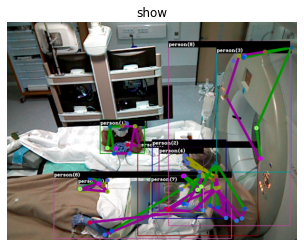

In [128]:
fig = plt.figure(figsize=(20,18))
print("Visualizing the 2D predictions from the Keypoint-MaskRCNN model")
plt.imshow(bgr2rgb(imgs_render_pred))
plt.title("show")
plt.axis("off")
plt.show()

In [129]:
imgs_render_pred

array([[[ 71,  59,  33],
        [ 72,  60,  34],
        [ 67,  60,  33],
        ...,
        [ 96, 109,  96],
        [ 94, 104,  98],
        [ 91, 101,  96]],

       [[ 76,  72,  40],
        [ 77,  74,  41],
        [ 77,  73,  43],
        ...,
        [ 96, 108,  92],
        [ 96, 106, 110],
        [ 92, 103, 106]],

       [[ 74,  74,  47],
        [ 79,  79,  51],
        [ 79,  79,  49],
        ...,
        [ 89, 102,  89],
        [ 91, 103,  99],
        [ 89, 101,  97]],

       ...,

       [[ 71,  87, 102],
        [ 72,  88, 103],
        [ 69,  89, 105],
        ...,
        [ 79,  90,  77],
        [ 83,  88,  86],
        [ 82,  87,  85]],

       [[ 69,  90, 103],
        [ 70,  91, 104],
        [ 75,  90, 105],
        ...,
        [ 81,  92,  79],
        [ 80,  90,  84],
        [ 79,  89,  83]],

       [[ 70,  92, 100],
        [ 71,  93, 101],
        [ 74,  94, 110],
        ...,
        [  0,   0,   0],
        [  0,   0,  53],
        [ 16,  14,   0]]